## Hydrogen Refueling Station Network

#### Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk #regression
#import chempy as che #chemistry
from scipy.optimize import fsolve
#import pyomo as pyo #optimization
#import chemicals as cls #chemical properties
#import ht #heat transfer library


# Python HRS - https://www.youtube.com/watch?v=3g301ybQKos

#inputs
#ambient (P,T), H2 (P,T), energy (kW), Water (kg/s, P, T), H2 (flowrate), controller variables

#outputs
#H2 (production rate), oxygen (production rate), fluid (P,T)

#### PEM

In [ ]:
#def PEM (Gordon, Vincent)
#Chemical EQN: H2O -> 1/2 O2 + H2
#Nernst EQN, Faraday's Law, Efficiency
def calculate_output_PEM(I_in, V_in, H2O_in, Energy_in, H2O_T, H2O_P, eff, R=8.314):
    dH2_dT = eff*I_in/(2*F_const) #Hydrogen production mol/s
    dO2_dT = dH2_dT/2 #Oxygen production mol/s
    dH2O_dT = H2O_in - dH2_dT #Water production mol/s

    #cell temperature (vary between -20C to 40C)
    Q_net = (I_in**2)*Res_e*t_op - 285830*dH2O_dT #electrolyte resistance heat - heat of reaction (endo)
    del_T = Q_net/(H2O_spec_heat*H2O_in*t_op) #per day
    Cell_T = Cell_T + del_T #per day

    #cell voltage
    #E_cell = 1.23-0.0009*(Cell_T-298)+(R*Cell_T/(4*F_const))*np.log((Pv_O2*(Pv_H2)**2)/Pv_H2O) #https://core.ac.uk/download/pdf/52394289.pdf
    I_den = I_in/Area
    V_cell = 1.23-0.18545*np.log(I_den)-0.10935*(I_den)-(-3.67397)*np.exp(-1.45761e-06)-0.18545*np.log(P/P_O2) #empirical formula from lab A1 Dylan -> can use non ideal gas to find partial P of O2
    Pwr_Req = V_cell * I_in #Power requirement

    return dH2_dT,dO2_dT,dH2O_dT,Cell_T,Pwr_Req

MW_H2 = 1.00794 #Molecular Weight of H2
MW_O2 = 31.9988 #Molecular Weight of O2
MW_H2O = 18.01528 #Molecular Weight of H2O
F_const = 96485.31 #faraday's constant
Cell_T = 293.15 #ambient cell temperature at start
t_op = 86400 #operation time in seconds of a day
Res_e = 1 #resistance of electrolyte
H2O_spec_heat = 4.184 #kj/kgK
PEM_eff = input("What is the efficiency %?: ") #75% according to H-TEC systems
OutP_H2 = 25 #Hydrogen output pressure (bar)


#### Compressor (output 200 bar)

In [ ]:
#def compressor to 200 bar (Rayan, Anand)
#RK equation https://chemicalprojects.wordpress.com/2014/07/06/equations-of-state/
#assumed 50°C temp for hydrogen
def calculate_rk_constants(Tc_hydrogen, Pc_hydrogen, R=8.314):
    """
    Calculate Redlich-Kwong constants 'a' and 'b' from critical temperature and pressure.

    Parameters:
    - Tc: Critical temperature in Kelvin
    - Pc: Critical pressure in Pascals
    - R: Gas constant in J/(mol K)

    Returns:
    - a: Redlich-Kwong constant 'a' in (Pa m^6/mol^2)
    - b: Redlich-Kwong constant 'b' in (m^3/mol)
    """
    a = 0.427 * ((R**2 * Tc_hydrogen**2.5) / Pc_hydrogen)
    b = 0.08664 * (R * Tc_hydrogen / Pc_hydrogen)
    return a, b
def calculate_compressibility_factor(P, V_hydrogen, T, R=8.314):
    """
    Calculate compressibility factor using the Redlich-Kwong equation.

    Parameters:
    - P: Pressure in Pascals
    - V: Molar volume in m^3/mol
    - T: Temperature in Kelvin
    - R: Gas constant in J/(mol K)

    Returns:
    - Z: Compressibility factor
    """
    virialB = 14.87        #assumed 50°C temp for hydrogen https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5325166/
    virialC = 340          #assumed 50°C temp for hydrogen
    Bprime = virialB/(R*T)
    Cprime = (virialC-Bprime**2)/(R*T)**2
    #Z = 1 + Bprime*P + P**2*Cprime
    Z = (P*V_hydrogen)/(R*T)
    return Z

In [ ]:
R_h2 = 4.124 # Gas constant for hydrogen, J/(g K)
Cp_h2 = 14.3 # Specific heat capacity for hydrogen, J/(g K)
def compressor_outputs(T1,P1,P2,eta):
    T2 = T1+(T1/eta)*((P2/P1)**(R_h2/Cp_h2)-1) # CHE 330 Lecture 7 Slide 25 - Assumes ideal gas behavior
    Ws = (Cp_h2*T1/eta)*((P2/P1)**(R_h2/Cp_h2)-1) # CHE 330 Lecture 7 Slide 25 - Assumes ideal gas behavior
    return T2,Ws
T1 = 30+273.15 # Hydrogen inlet temperature
P2 = 200 # Desired Hydrogen outlet pressure, bar 
comp_eff = 0.75 # Compressor efficiency (can be 0.7-0.8)
T2,Ws = compressor_outputs(T1,OutP_H2,P2,comp_eff)

In [ ]:
# Given conditions
T_hydrogen = 273.15 + 45  # Inlet to compressor (Temperature in Kelvin)
Tc_hydrogen = 33            # Critical temperature in Kelvin
Pc_hydrogen = 189*6895      # Critical Pressure in Pa
R_hydrogen = 4124  # Gas constant for hydrogen, J/(mol K)
eta_isentropic_assumed = 0.8  # Assume isentropic efficiency: can be 0.7 to 0.8
P_hydrogen = 25*100000     # Inlet Pressure in Pa (25 bar)
P_hydrogenatm = 25/1.013     # Inlet Pressure in atm
R = 0.08206 # L * atm / mol * K
V_hydrogen = ((T_hydrogen*R)/(P_hydrogenatm))/1000     # Molar volume in m^3/mol

# Calculate RK constants for hydrogen
a_hydrogen, b_hydrogen = calculate_rk_constants(Tc_hydrogen, Pc_hydrogen)

# Calculate compressibility factor
Z_hydrogen = calculate_compressibility_factor(P_hydrogen, V_hydrogen, T_hydrogen)

# compressor outputs
#T_output_comp1, P_output_comp1 = compressour_output(T_hydrogen, OutP_H2*100000, 200*100000, R_hydrogen, V_H2, eta_isentropic_assumed,Tc_hydrogen, Pc_hydrogen) # what would be desired outlet hydrogen pressure? 200 bar?

print(f"Compressibility Factor for Hydrogen (Z): {Z_hydrogen}")
print(f"Redlich-Kwong constants for Hydrogen - a: {a_hydrogen}, b: {b_hydrogen}")
#print(f"Compressor outlet conditions - T: {T_output_comp1}, P: {P_output_comp1}")

#### Transportation

In [ ]:
#compressor to transport ratio split

In [ ]:
#Transportation

#### Cascading pressure storage system

Inputs:  
Number of vehicles  
Initial hydrogen amount in vehicle's tank  
Vehicle tank capacity  
Hydrogen fill rate (can fix at 0.6kg H2/min [from external report] for now and then optimize later based on desired filling time?)  

Calculations:  
Initial tank temperature  
Initial tank pressure  
Transient tank temperature and pressure each minute (based on hydrogen fill rate)  

Assumptions:  
Hydrogen in pressure vessels > hydrogen required per day

c:\Users\Gordon\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


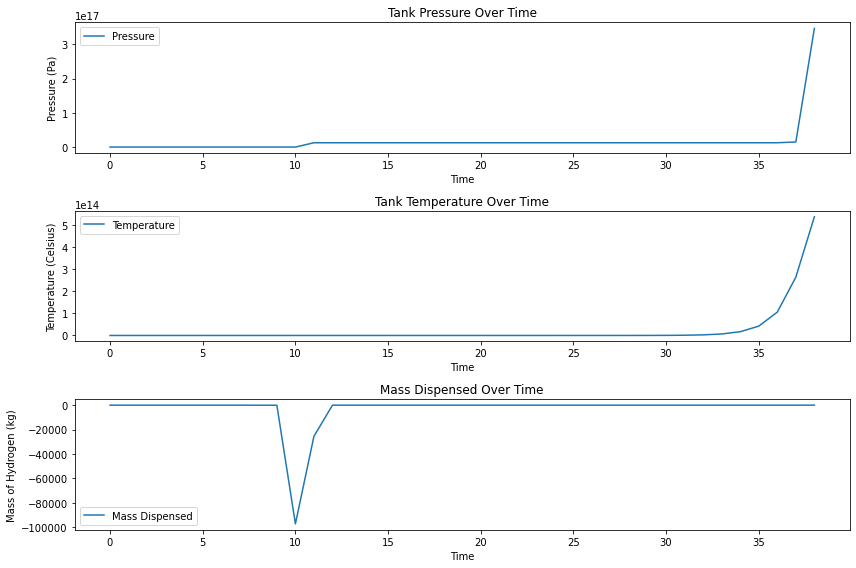

In [9]:
#Cascading
# Constants
Number_of_vehicles = 150 #specified fleet size
Initial_tank_amount = 0.1 #Litres of compressed H2
vehicle_tank_mass_capacity = 80 #kg of compressed H2
hydrogen_density = 0.08375
vehicle_tank_volume_capacity = vehicle_tank_mass_capacity/hydrogen_density*1000 #Litres of compressed H2
R = 8.314  # Ideal gas constant, J/(mol K)
R_hydrogen = 4124  # Gas constant for hydrogen, J/(mol K)
ambient_temperature = 20  # Ambient temperature, Celsius
maximum_hydrogen_mass = 6.0  # Maximum mass of hydrogen in the tank, kg
hydrogen_molar_mass = 2.01568 #kg/kmol molar mass fo hydrogen
hydrogen_moles = maximum_hydrogen_mass/hydrogen_molar_mass*1000 #moles of hydrogen
fill_rate = 0.6  # Hydrogen fill rate, kg/min

# Function to calculate Redlich-Kwong parameters a and b for hydrogen
def calculate_parameters(T, P):
    a = 0.42748 * (R_hydrogen ** 2) * (T ** 2.5) / P
    b = 0.08664 * R_hydrogen * T / P
    return a, b

# Function to calculate compressibility factor using Redlich-Kwong equation
def compressibility_factor(T, P, V, a, b):
    Z = (P * V) / (R * T) - b / V + (a / (V * (R * T) ** 0.5)) / V
    return Z

# Function to calculate the mass of hydrogen in the tank based on the ideal gas law
def calculate_mass_ideal_gas(P, V, T):
    return (P * V) / (R * T)

# Function to calculate the pressure and temperature change in the tank during dispensing
def calculate_tank_state(P, V, T, m_dispensed, a, b):
    # Calculate new mass in the tank
    m_current = calculate_mass_ideal_gas(P, V, T)
    m_new = m_current - m_dispensed

    # Calculate the new temperature using the Redlich-Kwong equation
    T_new = fsolve(lambda T: m_new - calculate_mass_ideal_gas(P, V, T), T)[0]

    # Calculate new volume using the ideal gas law
    V_new = R * T_new / P

    # Calculate new pressure using the Redlich-Kwong equation
    P_new = fsolve(lambda P: compressibility_factor(T_new, P, V_new, a, b) - compressibility_factor(T, P, V, a, b), P)[0]

    return P_new, V_new, T_new

# Function to simulate the dispensing process
def simulate_dispensing(P_initial, V_initial, T_initial, m_dispensed, a, b):
    # Lists to store simulation results
    time_points = []
    pressure_points = []
    temperature_points = []
    mass_points = []

    # Initial conditions
    P_current = P_initial
    V_current = V_initial
    T_current = T_initial
    m_current = calculate_mass_ideal_gas(P_initial, V_initial, T_initial)

    # Simulation loop
    while m_current < maximum_hydrogen_mass:
        # Store current state
        time_points.append(len(time_points))
        pressure_points.append(P_current)
        temperature_points.append(T_current)
        mass_points.append(m_current)

        # Calculate the amount of hydrogen to be dispensed
        m_dispensed = min(fill_rate, maximum_hydrogen_mass - m_current)

        # Calculate new state after dispensing
        P_current, V_current, T_current = calculate_tank_state(P_current, V_current, T_current, m_dispensed, a, b)
        m_current = calculate_mass_ideal_gas(P_current, V_current, T_current)

    # Append final state
    time_points.append(len(time_points))
    pressure_points.append(P_current)
    temperature_points.append(T_current)
    mass_points.append(m_current)

    return time_points, pressure_points, temperature_points, mass_points

# Function to plot simulation results
def plot_results(time, pressure, temperature, mass_dispensed):
    plt.figure(figsize=(12, 8))

    # Plot Pressure vs. Time
    plt.subplot(3, 1, 1)
    plt.plot(time, pressure, label='Pressure')
    plt.xlabel('Time')
    plt.ylabel('Pressure (Pa)')
    plt.legend()
    plt.title('Tank Pressure Over Time')

    # Plot Temperature vs. Time
    plt.subplot(3, 1, 2)
    plt.plot(time, temperature, label='Temperature')
    plt.xlabel('Time')
    plt.ylabel('Temperature (Celsius)')
    plt.legend()
    plt.title('Tank Temperature Over Time')

    # Plot Mass Dispensed vs. Time
    plt.subplot(3, 1, 3)
    plt.plot(time, mass_dispensed, label='Mass Dispensed')
    plt.xlabel('Time')
    plt.ylabel('Mass of Hydrogen (kg)')
    plt.legend()
    plt.title('Mass Dispensed Over Time')

    plt.tight_layout()
    plt.show()

# Calculate initial tank pressure and temperature iteratively
initial_temperature_guess = ambient_temperature
initial_pressure_guess = hydrogen_moles * R * (initial_temperature_guess + 273) / 

a_initial, b_initial = calculate_parameters(initial_temperature_guess, initial_pressure_guess)

# Simulate dispensing process
time_points, pressure_points, temperature_points, mass_points = simulate_dispensing(
    initial_pressure_guess, R * initial_temperature_guess / initial_pressure_guess, initial_temperature_guess,
    0, a_initial, b_initial
)

# Plot simulation results
plot_results(time_points, pressure_points, temperature_points, mass_points)


#### Dispensing

In [ ]:
#Heat Exchanger

In [ ]:
#Nozzle

#### Individual fuel stations

In [ ]:
#Tilbury South

In [ ]:
#Tilbury North

In [ ]:
#Ingersoll W

In [ ]:
#Woodstock E

In [ ]:
#Cambridge South

In [ ]:
#Cambridge North

In [ ]:
#Newcastle W

In [ ]:
#Port Hope E

In [ ]:
#Mallory Town South

In [ ]:
#Mallory Town North

In [ ]:
#Ingleside E